In [14]:
import sys
def category_encoders():
    package = 'category_encoders'
    try:
        return __import__(package)
    except ImportError:
        import sys
        !{sys.executable} -m pip install category_encoders
        return None


def imbalanced_learn():
    package = 'imbalanced-learn'
    try:
        return __import__(package)
    except ImportError:
        import sys
        !{sys.executable} -m pip install -U imbalanced-learn
        return None


def delayed():
    package = 'delayed'
    try:
        return __import__(package)
    except ImportError:
        import sys
        !{sys.executable} -m pip install delayed
        return None


In [15]:
category_encoders()
imbalanced_learn()
delayed()

Requirement already up-to-date: imbalanced-learn in /home/caio/anaconda3/lib/python3.8/site-packages (0.8.0)


<module 'delayed' from '/home/caio/anaconda3/lib/python3.8/site-packages/delayed/__init__.py'>

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import math
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,recall_score,accuracy_score, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV


In [17]:
def mean(l):
    acc = 0
    for i in l:
        acc+=i
    return acc/(len(l))

In [18]:
def std(l):
    m = mean(l)
    acc = 0
    for i in l:
        acc+= (i - m)**2
    return math.sqrt(acc/(len(l)))

In [19]:
plt.rcParams["figure.figsize"] = (12, 7)

In [20]:
# df = pd.read_csv("../raw_data.csv")
df = pd.read_csv("../final_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Editora       7560 non-null   object 
 1   ISBN          7560 non-null   object 
 2   Ano           7560 non-null   int64  
 3   Edição        7560 non-null   int64  
 4   Origem        7560 non-null   object 
 5   Encadernação  7560 non-null   object 
 6   Idioma        7560 non-null   object 
 7   País          7560 non-null   object 
 8   Páginas       7560 non-null   int64  
 9   preço         7560 non-null   float64
 10  nome          7560 non-null   object 
 11  categoria     7560 non-null   object 
 12  Autores       7559 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 767.9+ KB


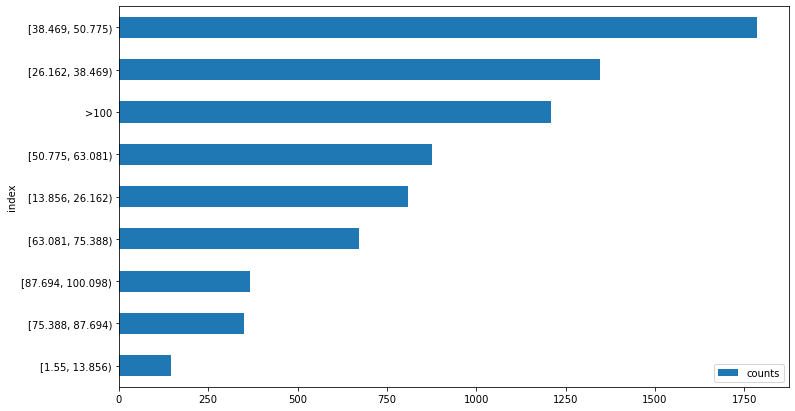

In [21]:
df.loc[df['preço']<=100,'preço_cat'] = pd.cut(df[df['preço']<=100]['preço'], bins=8, right=False)
df['preço_cat'] = df['preço_cat'].fillna('>100')
counts = df['preço_cat'].value_counts().reset_index(name="counts").sort_values(by='counts',ascending=True)
counts.plot(x='index',y='counts',kind='barh')
plt.show()

In [22]:
def cross_eval(X,y,pipe,cv,oversampler):
    results = []
    X_ = X.to_numpy()
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X_[train_ix, :], X_[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        #Over-sampling
        X_train_oversampled, y_train_oversampled = X_train, y_train
        if oversampler != None:
           X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)
        # print(f'X_train.shape={X_train.shape};\ty_train.shape={y_train.shape}\tX_train_oversampled.shape={X_train_oversampled.shape};\ty_train_oversampled.shape={y_train_oversampled.shape}')
        # print(f'Exemplos por classe')
        # test = pd.DataFrame(y_train_oversampled,columns=['y'])
        # print(test['y'].value_counts())
        #Training
        pipe.fit(X_train_oversampled, y_train_oversampled)
        #Testing
        y_pred = pipe.predict(X_test)
        plot_confusion_matrix(pipe, X_test, y_test)
        plt.xticks(rotation=45)
        plt.show()
        # test = pd.DataFrame(y_pred,columns=['y'])
        # print(test['y'].value_counts())
        metrics = {}
        metrics['precision'] = precision_score(y_test, y_pred,zero_division=1, average='weighted')
        metrics['recall'] = recall_score(y_test, y_pred, average='weighted')
        metrics['f1'] = f1_score(y_test, y_pred, average='weighted')
        #Encoding y for use in roc_auc
        le = preprocessing.LabelEncoder()
        le.fit(y)
        y_test_ = le.transform(y_test)
        metrics['roc_auc'] = roc_auc_score(y_test_, pipe.predict_proba(X_test),multi_class='ovr')
        results.append(metrics)
    df_results = pd.DataFrame(results)
    return df_results

In [23]:
X = df[['Ano','Edição','Páginas']]
y = df['preço_cat']
y = y.to_numpy().astype(str)

In [24]:
cv_outer = KFold(n_splits=10, shuffle=True, random_state=42)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=64)

In [25]:
encoder=ce.OneHotEncoder(cols='Origem',handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encoder.fit_transform(df[['Origem','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Origem_NACIONAL,Origem_IMPORTADO,Origem_USADO,preço
0,1.0,0.0,0.0,49.90
1,1.0,0.0,0.0,59.90
2,1.0,0.0,0.0,130.00
3,1.0,0.0,0.0,38.42
4,1.0,0.0,0.0,49.90
...,...,...,...,...
7555,1.0,0.0,0.0,114.00
7556,1.0,0.0,0.0,98.00
7557,1.0,0.0,0.0,49.90
7558,1.0,0.0,0.0,84.90


In [26]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [27]:
encoder=ce.OneHotEncoder(cols='País',handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encoder.fit_transform(df[['País','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,País_BRASIL,País_ESTADOS UNIDOS,País_PORTUGAL,País_FRANÇA,País_INGLATERRA,País_ALEMANHA,País_ESPANHA,País_ARGENTINA,País_ITALIA,País_HOLANDA,País_MEXICO,preço
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.90
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.42
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
...,...,...,...,...,...,...,...,...,...,...,...,...
7555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.00
7556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.00
7557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
7558,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.90


In [28]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [29]:
encoder=ce.OneHotEncoder(cols='Idioma',handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encoder.fit_transform(df[['Idioma','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Idioma_PORTUGUÊS,Idioma_INGLÊS,Idioma_PORT. PORTUGAL,Idioma_FRANCÊS,Idioma_ESPANHOL,Idioma_ITALIANO,Idioma_JAPONÊS,Idioma_ALEMÃO,preço
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.90
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.42
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
...,...,...,...,...,...,...,...,...,...
7555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.00
7556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.00
7557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
7558,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.90


In [30]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [31]:
encoder=ce.OneHotEncoder(cols='Encadernação',handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encoder.fit_transform(df[['Encadernação','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Encadernação_BROCHURA,Encadernação_CAPA DURA,Encadernação_LÂMINA,Encadernação_FLEXIVEL,Encadernação_CAPA DURA C/SOBRECAP,Encadernação_ESPIRAL,Encadernação_CAPA DURA COM SOBRE-CAPA,Encadernação_ENCADERNADO,Encadernação_COURO,Encadernação_GRAMPO,Encadernação_POP-UP,Encadernação_FLEXÍVEL,Encadernação_LIVRO PARA BANHO,preço
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.90
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.42
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.00
7556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.00
7557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.90
7558,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.90


In [32]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [33]:
encoder= ce.BaseNEncoder(cols=['categoria'],return_df=True,base=5)
data_encoded=encoder.fit_transform(df[['categoria','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,categoria_0,categoria_1,categoria_2,categoria_3,preço
0,0,0,0,1,49.90
1,0,0,0,2,59.90
2,0,0,0,2,130.00
3,0,0,0,3,38.42
4,0,0,0,3,49.90
...,...,...,...,...,...
7555,0,1,2,3,114.00
7556,0,1,2,3,98.00
7557,0,1,2,3,49.90
7558,0,1,2,4,84.90


In [34]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [35]:
encoder= ce.BaseNEncoder(cols=['Editora'],return_df=True,base=5)
data_encoded=encoder.fit_transform(df[['Editora','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Editora_0,Editora_1,Editora_2,Editora_3,Editora_4,Editora_5,preço
0,0,0,0,0,0,1,49.90
1,0,0,0,0,0,2,59.90
2,0,0,0,0,0,3,130.00
3,0,0,0,0,0,4,38.42
4,0,0,0,0,1,0,49.90
...,...,...,...,...,...,...,...
7555,0,0,0,0,2,1,114.00
7556,0,0,0,0,2,1,98.00
7557,0,0,0,0,2,1,49.90
7558,0,1,0,4,3,3,84.90


In [36]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [37]:
encoder= ce.BaseNEncoder(cols=['Autores'],return_df=True,base=5)
data_encoded=encoder.fit_transform(df[['Autores','preço']])
data_encoded

/home/caio/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Autores_0,Autores_1,Autores_2,Autores_3,Autores_4,Autores_5,Autores_6,preço
0,0,0,0,0,0,0,1,49.90
1,0,0,0,0,0,0,2,59.90
2,0,0,0,0,0,0,3,130.00
3,0,0,0,0,0,0,4,38.42
4,0,0,0,0,0,1,0,49.90
...,...,...,...,...,...,...,...,...
7555,0,1,0,4,1,0,4,114.00
7556,0,1,1,1,0,0,4,98.00
7557,0,1,0,4,1,0,3,49.90
7558,0,1,1,0,0,4,2,84.90


In [38]:
X = X.join(data_encoded.drop(columns=["preço"],axis=1))

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 55 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Ano                                    7560 non-null   int64  
 1   Edição                                 7560 non-null   int64  
 2   Páginas                                7560 non-null   int64  
 3   Origem_NACIONAL                        7560 non-null   float64
 4   Origem_IMPORTADO                       7560 non-null   float64
 5   Origem_USADO                           7560 non-null   float64
 6   País_BRASIL                            7560 non-null   float64
 7   País_ESTADOS UNIDOS                    7560 non-null   float64
 8   País_PORTUGAL                          7560 non-null   float64
 9   País_FRANÇA                            7560 non-null   float64
 10  País_INGLATERRA                        7560 non-null   float64
 11  País

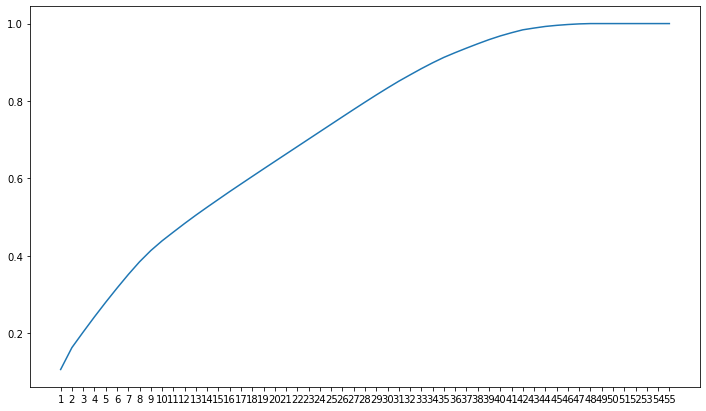

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA().fit(X_scaled)
variances = np.cumsum(pca.explained_variance_ratio_)
ticks = np.arange(1, X.shape[1]+1, step=1)
plt.plot(ticks,variances)
plt.xticks(ticks)
plt.show()

In [41]:
feature_number = 35

In [42]:
results_overview = []
indexes = []

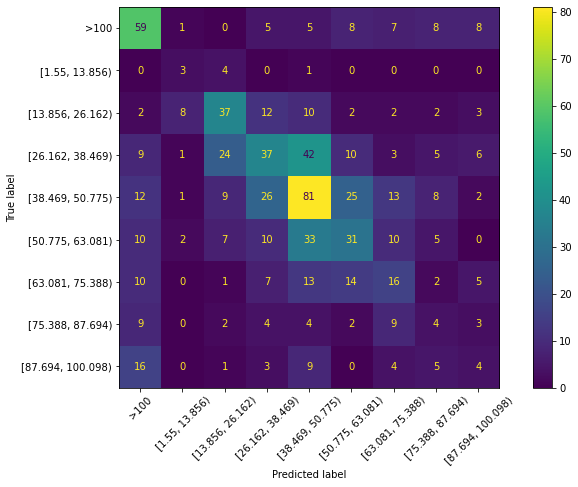

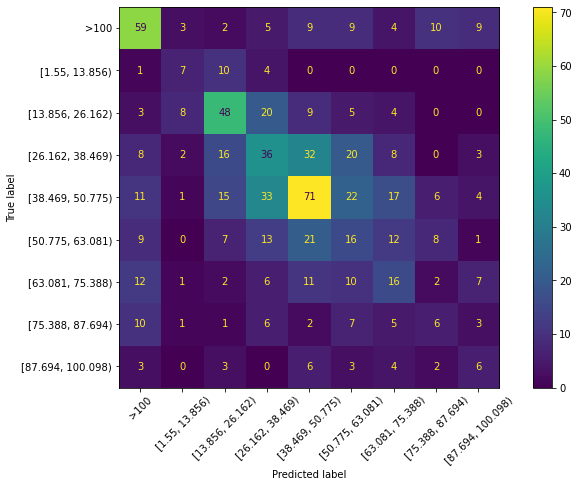

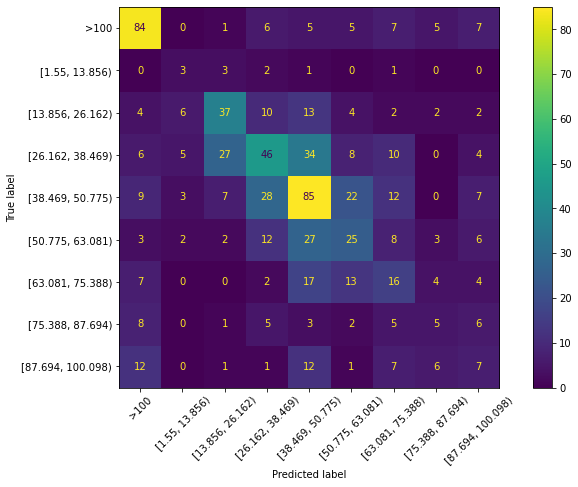

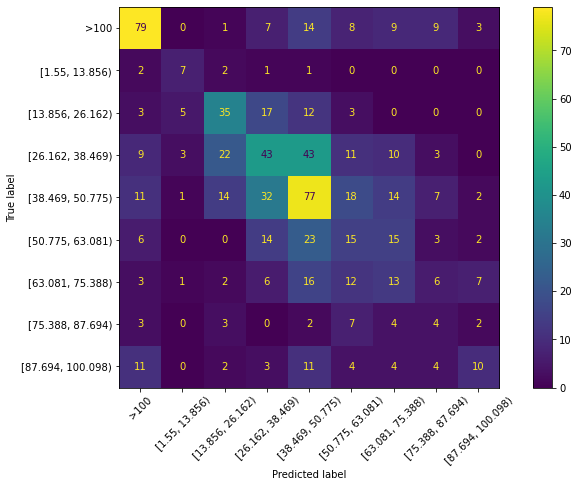

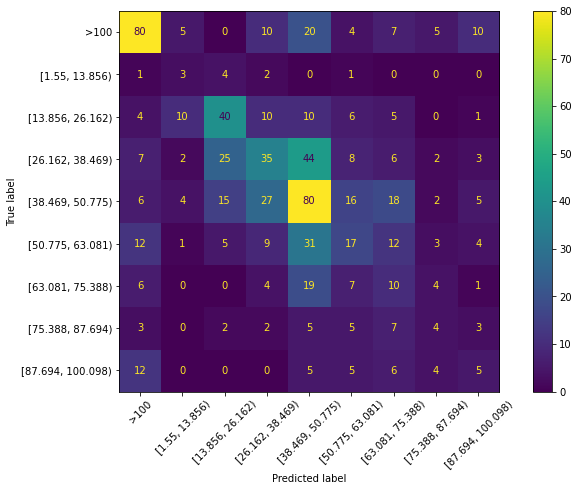

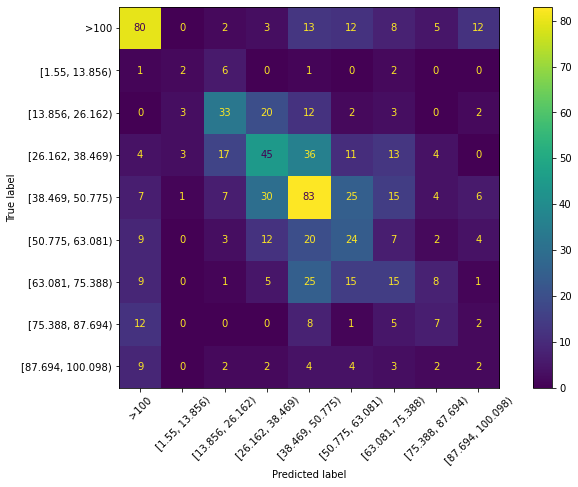

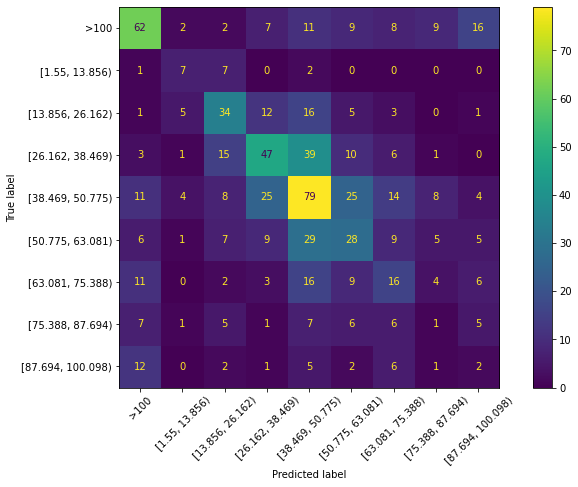

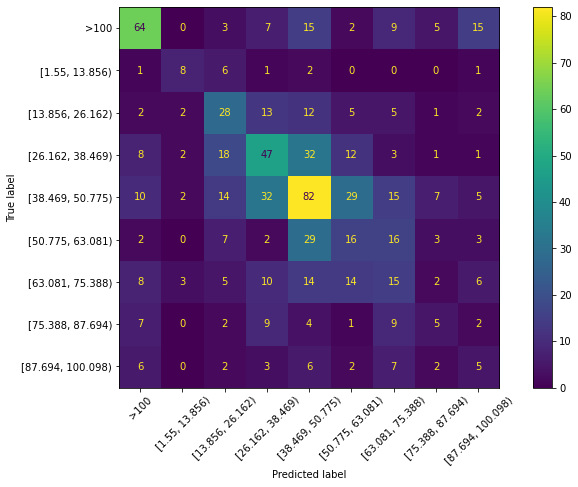

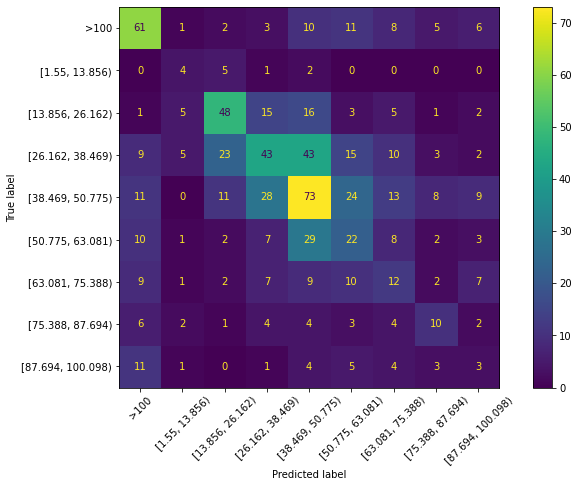

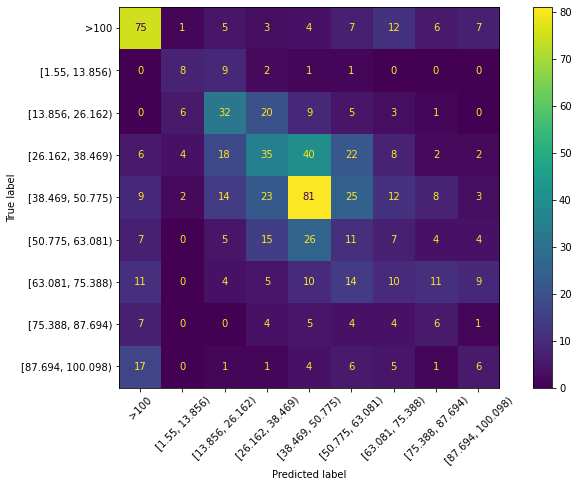

In [43]:
oversampler = SMOTE(random_state=42)
model = RandomForestClassifier(
                bootstrap=False,
                max_depth=30,
                max_features='auto',
                min_samples_leaf=1,
                min_samples_split=2,
                n_estimators=1800
            )
pipe = Pipeline([ ('scaler', StandardScaler()) , ('pca', PCA(n_components=feature_number)) , ('cls',model) ])
results = cross_eval(X,y,pipe,cv_outer,oversampler)

In [44]:
results

,precision,recall,f1,roc_auc
0,0.352023,0.359788,0.352746,0.704778
1,0.351808,0.350529,0.350550,0.698421
2,0.402058,0.407407,0.402523,0.720320
3,0.378475,0.374339,0.373490,0.730688
4,0.367538,0.362434,0.361122,0.702800
5,0.385211,0.384921,0.384029,0.699724
6,0.367526,0.365079,0.365029,0.709717
7,0.362121,0.357143,0.358637,0.682312
8,0.369634,0.365079,0.364745,0.692440
9,0.346034,0.349206,0.345972,0.695084


In [45]:
mean_dict = results.describe().loc['mean',:].to_dict()
indexes.append('RandomForest-tuned')
results_overview.append(mean_dict)

In [46]:
df_results_overview = pd.DataFrame(results_overview,index=indexes)
df_results_overview

,precision,recall,f1,roc_auc
RandomForest-tuned,0.368243,0.367593,0.365884,0.703628


In [47]:
df_results_overview.sort_values(by='f1',ascending=False)

,precision,recall,f1,roc_auc
RandomForest-tuned,0.368243,0.367593,0.365884,0.703628
